In [30]:
import numpy as np
import pandas as pd
import mymath
import os
import finance_momentum as fmom
import my_plot
import lineplot_oo3 as lp
import scipy.stats as spstats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Data from Quandl

In [2]:
import Quandl
datadir = '../Historical Data/'

In [3]:
def csv_file_path(filepref,subdir=''):
    filename = filepref + '.csv'
    return os.path.join(subdir,filename)

In [4]:
def get_and_save_quandl_data(code,filepref,subdir=datadir):
    data = Quandl.get(code)
    save_to_csv(data,filepref,subdir=subdir)
    
def save_to_csv(data,filepref,subdir=datadir):
    filepath = csv_file_path(filepref,subdir=subdir)
    data.to_csv(filepath)

In [5]:
codes = ['YAHOO/INDEX_GSPC','YAHOO/FUND_VBMFX','BUNDESBANK/BBK01_WT5511'] # stocks, bonds, gold
fileprefs = ['SP500_DEMO','BOND_DEMO','GOLD_DEMO'] # names for save files

In [6]:
for code, filepref in zip(codes,fileprefs):
    get_and_save_quandl_data(code,filepref)

# S&P 500 Momentum

## Read Data from File, Plot

In [7]:
filepath = csv_file_path(fileprefs[0],subdir=datadir)
stockseries = fmom.MomentumTimeSeries.from_quandl_file(
    filepath=filepath,name='Stocks',adjclosekey='Close',
    lowkey='Low',highkey='High',startdate=None,enddate=None)

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


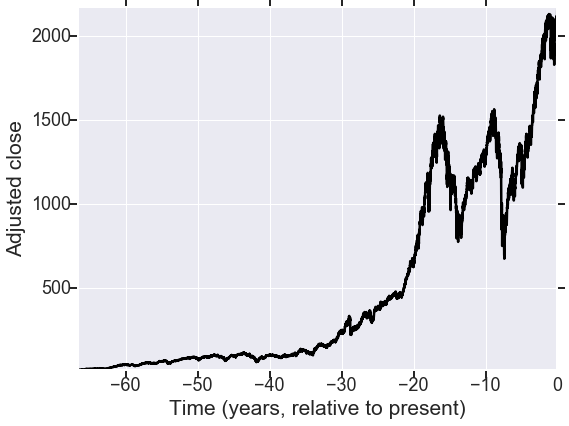

In [8]:
lp.my_quick_plot([stockseries.plot_data()],
                 xlabel='Time (years, relative to present)',ylabel='Adjusted close')

## Momentum Analysis

Momentum is defined as the current rate of return of the index
It's computed by finding the average rate of return over a window from t - dt to dt
Here, I'll explore windows in the range of days (1-5), but other strategies use windows on the order of months

In [10]:
dt = 5
mom = stockseries.momentum(dt=-dt)
momnew = mom[~np.isnan(mom)] # remove nan

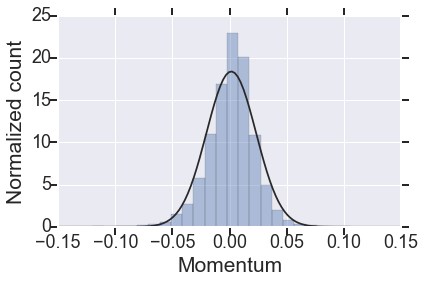

In [11]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(momnew,kde=None,fit=spstats.norm,ax=ax);
my_plot.pretty_figure(fig,xlabel='Momentum',ylabel='Normalized count',axisbounds=[-0.15,0.15,0,25]);

In [12]:
meanmom = np.mean(momnew)
print('Average momentum: {:.2f}%'.format(100*meanmom))
stdmom = np.std(momnew)
print('Standard deviation of momentum: {:.2f}%'.format(100*stdmom))

Average momentum: 0.15%
Standard deviation of momentum: 2.16%


In [13]:
# Compare Percentiles with Normal Distribution
def percentage_of_data_more_than_n_sigma_away(data,n,mean=None,std=None):
    if mean is None:
        mean = np.mean(data)
    if std is None:
        std = np.std(data)
    dhigh = mean + n*std
    dlow = mean - n*std
    return 100 - (spstats.percentileofscore(data,dhigh) - spstats.percentileofscore(data,dlow))

In [14]:
for i in range(2,6):
    percactual = percentage_of_data_more_than_n_sigma_away(momnew,i)
    percnormal = 100*(1 - (spstats.norm.cdf(i) - spstats.norm.cdf(-i)))
    print('{}*sigma --- Actual: {:.2f}%; Expected (Gaussian): {:2f}%'.format(i,percactual,percnormal))

2*sigma --- Actual: 4.65%; Expected (Gaussian): 4.550026%
3*sigma --- Actual: 1.18%; Expected (Gaussian): 0.269980%
4*sigma --- Actual: 0.41%; Expected (Gaussian): 0.006334%
5*sigma --- Actual: 0.18%; Expected (Gaussian): 0.000057%


In [15]:
# Compare Kurtosis
print('Kurtosis --- Actual: {:.2f}; Expected (Gaussian): {:.2f}'.format(spstats.kurtosis(momnew,fisher=False),3))

Kurtosis --- Actual: 12.31; Expected (Gaussian): 3.00


## Analyze Correlation between Momentum and Bracket Trade Success

Bracket trade is when we buy (short sell), and sell (buy back and repay) when the price has either moved up by a percentage rhigh or down by a percentage -rlow
(Thus, our gain is "bracketed" by rlow/rhigh)

### Code for Plotting

In [31]:
def bracket_data(stockseries,dt,rlow,rhigh):
    """Generate the bracket data --- success of bracket trade vs. momentum"""
    mom = stockseries.momentum(dt=-1) # calculate momentum for window of dt
    bracket = stockseries.bracket_returns(rlow,rhigh)
    return mom_corr_data(mom,bracket)

def bin_data(data,low=5,high=95,nbins=20):
    """Bin data with low and high cutoffs"""
    datalow = np.percentile(data,low)
    datahigh = np.percentile(data,high)
    return np.linspace(datalow,datahigh,nbins+1)

def mom_corr_data(momentum,bracketreturns,mlow=5,mhigh=95,nbins=20):
    """Correlate momentum with bracket trade success:
    Bin momentum and calculate number of successes of bracket trade in each bin"""
    def data_point():
        idxnan1 = np.isnan(momentum)
        idxnan2 = np.isnan(bracketreturns[:,0])
        idxnonan = ~(idxnan1 | idxnan2)
        momentumnonan = momentum[idxnonan]
        bracketnonan = bracketreturns[idxnonan,0]
        bins = bin_data(momentumnonan,mlow,mhigh,nbins)
        for binlow, binhigh in mymath.pairwise(bins):
            idx = (binlow <= momentumnonan) & (momentumnonan < binhigh)
            bracketcurr = bracketnonan[idx]
            count = np.sum(bracketcurr)
            n = np.size(bracketcurr)
            r = (binhigh + binlow)/2
            yield [r,count,n]
    return np.array([obs for obs in data_point()])

def bracket_plot(ax,data,yplot='Count',style='Plot',color='red'):
    """Plot the bracket data, either as a line or bar plot"""
    if yplot == 'Count':
        y = data[:,1]
        ylabel = 'Net count (high minus low)'
    elif yplot == 'Probability':
        y = data[:,1]/data[:,2]
        ylabel = 'P(high) - P(low)'
    if style == 'Bar':
        sns.barplot(x=data[:,0],y=y,color=color,ax=ax)
        labellist = ['{:.1f}'.format(100*momentum) for momentum in data[:,0]]
        ax.set_xticklabels(tuple(labellist));
    elif style == 'Plot':
        ax.plot(data[:,0],y,color=color)
    xlabel = 'Momentum (%)'
    ax.set_ylim([-0.2,0.4])
    return xlabel, ylabel

### Correlation

(-0.2, 0.4)

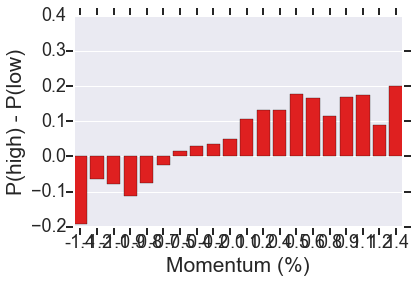

In [33]:
fig = plt.figure()
ax = fig.gca()
bracketdata = bracket_data(stockseries,dt=-1,rlow=-0.01,rhigh=0.01)
xlabel, ylabel = bracket_plot(ax,bracketdata,yplot='Probability',style='Bar')
my_plot.pretty_figure(fig,xlabel=xlabel,ylabel=ylabel);
ax.set_ylim(-0.2,0.4);
# There appears to be a correlation!

## Implement in Quantopian

Fairly easy using the Quantopian API --- only about 100 lines of Python!

## What happened?

Backtesting was from 2004 - present
But, data series we analyzed was from 1950 (!) - present
Perhaps behavior of the market changed recently

### Stock Data

In [24]:
transitiondate = '1/1/1990'

stockseriesbefore = fmom.MomentumTimeSeries.from_quandl_file(
    filepath=filepath,name='Stocks',adjclosekey='Close',
    lowkey='Low',highkey='High',startdate=None,enddate=transitiondate)

stockseriesafter = fmom.MomentumTimeSeries.from_quandl_file(
    filepath=filepath,name='Stocks',adjclosekey='Close',
    lowkey='Low',highkey='High',startdate=transitiondate,enddate=None)

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


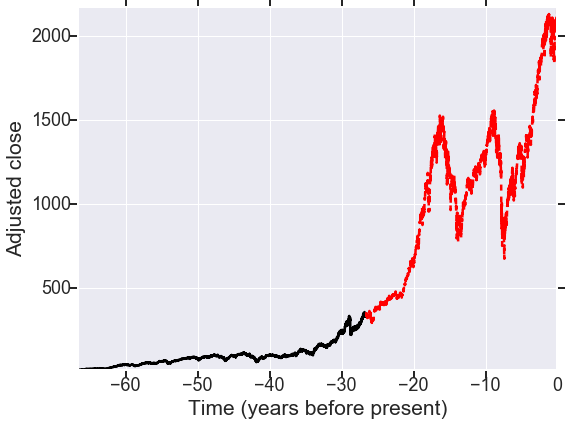

In [25]:
lp.my_quick_plot([stockseriesbefore.plot_data(),stockseriesafter.plot_data()],
                 xlabel='Time (years before present)',ylabel='Adjusted close')

### Correlation Before

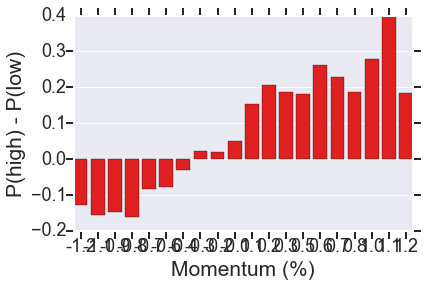

In [34]:
fig = plt.figure()
ax = fig.gca()
bracketdatabefore = bracket_data(stockseriesbefore,dt=-1,rlow=-0.01,rhigh=0.01)
xlabel, ylabel = bracket_plot(ax,bracketdatabefore,yplot='Probability',style='Bar',color='red')
my_plot.pretty_figure(fig,xlabel=xlabel,ylabel=ylabel)
ax.set_ylim(-0.2,0.4);

### Correlation After

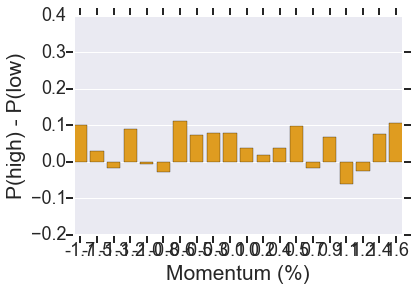

In [35]:
fig = plt.figure()
ax = fig.gca()
bracketdataafter = bracket_data(stockseriesafter,dt=-1,rlow=-0.01,rhigh=0.01)
xlabel, ylabel = bracket_plot(ax,bracketdataafter,yplot='Probability',style='Bar',color='orange')
my_plot.pretty_figure(fig,xlabel=xlabel,ylabel=ylabel)
ax.set_ylim(-0.2,0.4);

## Summary

In fact, market behavior does appear to have changed recently! Before 1990, there is a strong correlation between the momentum of the market and the likelihood of winning on a bracket trade; after 1990, the correlation disappears. I suspect this is because trading became more sophisticated, and these sorts of easy correlations were exploited by professionals, causing them to disappear from the market.